In [1]:
import gluonts
gluonts.__version__

'0.4.2'

In [2]:
import mxnet
mxnet.__version__

'1.4.1'

In [3]:
# standard imports
import numpy as np
import pandas as pd

# Vis
%matplotlib inline
import matplotlib.pyplot as plt
from pprint import pprint

# mxnet
import mxnet as mx

# gluonts
from gluonts.dataset.util import to_pandas

# imports from utility function
import utils_gluonts10 as utils
from utils_gluonts10 import get_dataset, dataset_recipes
from utils_gluonts10_deepar import deepar


INFO:root:Using CPU


In [16]:
dataname = "m4_monthly_industry"
dataset = utils.get_dataset(dataname, regenerate=False)

INFO:root:using dataset already processed in path /home/ec2-user/.mxnet/gluon-ts/datasets/m4_monthly_industry.


In [18]:
print(f"Available datasets: {list(dataset_recipes.keys())}")

Available datasets: ['m4_daily', 'm4_daily_domain', 'm4_hourly', 'm4_monthly', 'm4_monthly_atm', 'm4_monthly_dates', 'm4_monthly_demographic', 'm4_monthly_domain', 'm4_monthly_finance', 'm4_monthly_industry', 'm4_monthly_macro', 'm4_monthly_micro', 'm4_monthly_micro_atm', 'm4_monthly_nonmicro_10975_seed42', 'm4_monthly_nonmicro_10975_seed43', 'm4_monthly_nonmicro_10975_seed44', 'm4_monthly_nonmicro_10975_seed45', 'm4_monthly_nonmicro_10975_seed46', 'm4_monthly_nonmicro_10975_seed47', 'm4_monthly_nonmicro_10975_seed48', 'm4_monthly_nonmicro_10975_seed49', 'm4_monthly_nonmicro_10975_seed50', 'm4_monthly_nonmicro_10975_seed51', 'm4_monthly_other', 'm4_quarterly', 'm4_quarterly_atm', 'm4_quarterly_dates', 'm4_quarterly_demographic', 'm4_quarterly_domain', 'm4_quarterly_finance', 'm4_quarterly_industry', 'm4_quarterly_macro', 'm4_quarterly_micro', 'm4_quarterly_other', 'm4_weekly', 'm4_weekly_domain', 'm4_weekly_id', 'my_weekly_tm', 'm4_yearly', 'm4_yearly_demographic', 'm4_yearly_domain', 

In [19]:
# get the first time series in the training set
train_entry = next(iter(dataset.train))
test_entry = next(iter(dataset.test))

# check keys
print(train_entry.keys())
print(test_entry.keys())

dict_keys(['start', 'target', 'feat_static_cat', 'source'])
dict_keys(['start', 'target', 'feat_static_cat', 'source'])


In [20]:
train_entry

{'start': Timestamp('1750-01-31 00:00:00', freq='M'),
 'target': array([ 8370.,  8430.,  7880.,  8160.,  8290.,  8000.,  8240.,  7840.,
         8040.,  7930.,  7500.,  6610.,  7210.,  7390.,  6840.,  6600.,
         6810.,  6580.,  6040.,  6450.,  6670.,  6210.,  6330.,  6100.,
         6700.,  6690.,  5650.,  5270.,  5170.,  5870.,  6230.,  6730.,
         7370.,  7500.,  7670.,  6450.,  7140.,  6690.,  6650.,  7240.,
         7630.,  7310.,  7410.,  7720.,  7310.,  7030.,  6250.,  6430.,
         7100.,  6650.,  6200.,  6550.,  6750.,  6570.,  6540.,  6540.,
         6930.,  7340.,  7210.,  7190.,  7040.,  7460.,  8080.,  8910.,
         9330.,  9220.,  9280.,  9090.,  8990.,  8930.,  9110.,  9420.,
        10010.,  9740., 10100.,  9610.,  9810.,  9550.,  9660.,  9910.,
        10090.,  9630.,  9570.,  9290.,  9600.,  9370.,  9370.,  9460.,
         9180.,  9650.,  9400.,  9240.,  9210.,  8840.,  9090.,  9390.,
         9560.,  9590.,  9510.,  9620.,  9480.,  9930.,  9770.,  9490.,


## Plot Series

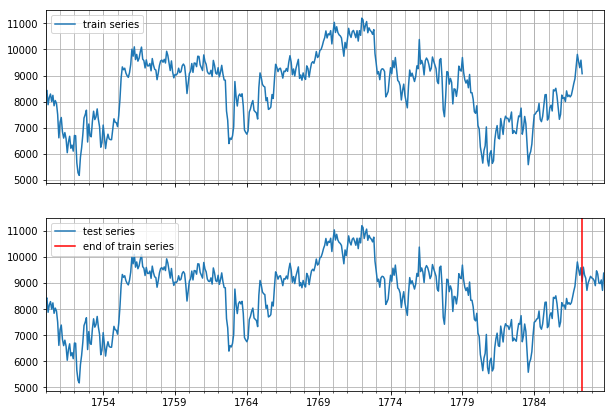

In [21]:
test_series = to_pandas(test_entry)
train_series = to_pandas(train_entry)

fig, ax = plt.subplots(2, 1, sharex=True, sharey=True, figsize=(10, 7))

train_series.plot(ax=ax[0])
ax[0].grid(which="both")
ax[0].legend(["train series"], loc="upper left")

test_series.plot(ax=ax[1])
ax[1].axvline(train_series.index[-1], color='r') # end of train dataset
ax[1].grid(which="both")
ax[1].legend(["test series", "end of train series"], loc="upper left")

plt.show()

In [22]:
from gluonts.trainer import Trainer
from gluonts.evaluation.backtest import make_evaluation_predictions
from gluonts.evaluation import Evaluator

from gluonts.model.deepar import DeepAREstimator

In [23]:
######################
### deepar wrapper ###
def deepar(data="m4_quarterly", seed=42, epochs=100, batches=50):

    dataset = get_dataset(data, regenerate=False)
    mx.random.seed(seed)
    np.random.seed(seed)

    trainer = Trainer(
        ctx=mx.cpu(0),
        epochs=epochs,
        num_batches_per_epoch=batches,
        learning_rate=1e-3,
    )
    
    estimator = DeepAREstimator(
        trainer=trainer,
        cardinality= [
            feat_static_cat.cardinality 
            for feat_static_cat in dataset.metadata.feat_static_cat
        ],
        context_length=dataset.metadata.prediction_length,
        prediction_length=dataset.metadata.prediction_length,
        freq=dataset.metadata.freq,
        use_feat_static_cat=True
    )

    # predictor = estimator.train(training_data=dataset.train,
    #                             validation_data=dataset.test)
    predictor = estimator.train(training_data=dataset.train)

    forecast_it, ts_it = make_evaluation_predictions(
        dataset.test, predictor=predictor, num_samples=100
    )

    agg_metrics, item_metrics = Evaluator()(
        ts_it, forecast_it, num_series=len(dataset.test)
    )

    metrics = ["MASE", "sMAPE", "MSIS", "wQuantileLoss[0.5]", "wQuantileLoss[0.9]"]
    output = {key: round(value, 8) for key, value in agg_metrics.items() if key in metrics}

    output["seed"] = seed
    output["epochs"] = epochs
    output["num_batches"] = batches

    df = pd.DataFrame([output])

    return df


## Results

In [ ]:
results = pd.DataFrame()

for i in range(45, 52):
    print("Seed:", i)
    df = deepar(data="m4_monthly_industry", seed=i, epochs=100, batches=100)
    pprint(df)
    results = results.append(df)

results

In [ ]:
results = pd.DataFrame()

for i in range(42, 52):
    print("Seed:", i)
    df = deepar(data="m4_monthly_industry", seed=i, epochs=200, batches=100)
    pprint(df)
    results = results.append(df)

results